<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели картинку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)


### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота )))))
5. Whatever comes to your head

# Предобработка текстов из датасета

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!tar -xvzf '/content/gdrive/My Drive/Image Captioning/handout.tar (1).gz'

data/
data/captions_tokenized.json
data/image_codes.npy


In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import numpy as np
import json

# Загрузим датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [5]:
# Посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлых занятиях. Батч должен выглядеть примерно так:

```
[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,    2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,    2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,  393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
```
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезаются, в начале и конце по коду символа начала и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

Разделим датасет на Train и Val:

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

Посчитаем частоту встречаемости слов в captions:

In [0]:
from collections import Counter
token_counts = Counter()

for cap in train_captions:
  for line in cap:
        token_counts.update(line.split())

In [8]:
token_counts.most_common(10)

[('a', 880595),
 ('.', 400192),
 ('on', 194324),
 ('of', 183429),
 ('the', 178014),
 ('in', 165666),
 ('with', 139145),
 ('and', 126488),
 ('is', 88471),
 ('man', 65783)]

Загрузим предобученные эмбеддинги:

In [47]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

--2020-02-22 03:30:45--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2020-02-22 03:30:45--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2020-02-22 03:30:46--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [49]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [0]:
w2v_model = {}

with open(f'/content/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        w2v_model[line[0]] = np.array(line[1:]).astype(np.float)

Построим словарь токенов:

In [0]:
min_count = 5
tokens = [token for token, num in token_counts.items() if (token in w2v_model and num>=min_count)]

Добавим в словарь специальные символы:

In [0]:
UNK, PAD, BOS, EOS = "UNK", "PAD", "<bos>", "<eos>"
tokens = [PAD, BOS, EOS, UNK] + tokens

In [0]:
n_tokens = len(tokens)

In [54]:
n_tokens

9656

Подготовим словарь для перевода токенов в индексы:

In [0]:
token_to_id = {t:i for i, t in enumerate(tokens)}

In [0]:
UNK_IDX, PAD_IDX = token_to_id["UNK"], token_to_id["PAD"]
BOS_IDX, EOS_IDX = token_to_id["<bos>"], token_to_id["<eos>"]

Из эмбеддингов слов из словаря сформируем таблицу для передачи в слой nn.Embedding:

In [58]:
numpy_embeddings = np.zeros(shape=[len(tokens), 300],dtype=np.float32)

for word in tokens:
    if word in w2v_model:
        vector = w2v_model[word]
        index  = token_to_id[word]
        numpy_embeddings[index] = vector
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([9656, 300])

In [0]:
#  Преобразование предложений в матрицу индексов с паддингами
def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        max_len: if specified, 
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len+2), np.int32(PAD_IDX))
    for i,seq in enumerate(sequences):
        row_ix = [BOS_IDX] + [token_to_id.get(word, UNK_IDX) for word in seq[:max_len]] + [EOS_IDX]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Посмотрим, какой длины предложения есть в нашем датасете. Это поможет нам с выбором max_len для генерации.

In [0]:
lens = []
for cap in captions:
  for str_cap in cap:
    lens.append(len(str_cap.split()))

In [0]:
np.mean(lens), np.min(lens), np.max(lens)

(11.292223152163805, 6, 57)

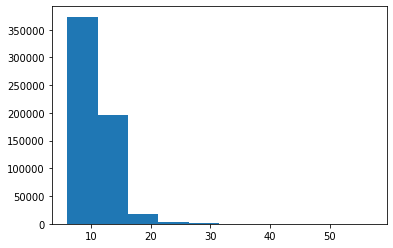

In [0]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

Подавляющее большинство предложений не превосходит длины 30 токенов.

## Подготовка references для расчета BLEU


In [0]:
batch_size = 32

In [0]:
val_size = len(val_captions) // batch_size * batch_size

In [0]:
# Для расчета bleu
references = []
for cap in val_captions[:val_size]:
  new_cap = []
  for str_cap in cap:
    new_cap.append(list(str_cap.split()))
  references.append(new_cap)

In [0]:
references[0][0]

['two', 'pizzas', 'that', 'are', 'sitting', 'on', 'a', 'stove', '.']

In [0]:
np.array(references).shape

(11808, 5)

# Построение модели

Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens

        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=PAD_IDX) 
        self.drop = nn.Dropout(0.4) 
            
        # lstm
        self.lstm = nn.LSTMCell(emb_size, lstm_units) 
            
        # линейный слой для получения логитов
        self.fc = nn.Linear(lstm_units, n_tokens) 

        self.init_weights()
        
    def forward(self, image_vectors, captions_ix=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch_size, cnn_feature_size]
        :param captions_ix: [batch_size, max_len]
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch_size, max_len, n_tokens]
        """
        batch_size = image_vectors.shape[0]
        
        if captions_ix is None:
          max_len = 30
        else:
          max_len = captions_ix.shape[1]
        
        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.n_tokens).to(device)

        # init h0 and c0
        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)) 
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            # (batch_size, emb_size)
            lstm_in = self.drop(self.embed(captions_input)) 

            # (batch_size, lstm_units)
            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            # (batch_size, n_tokens)
            output = self.fc(hidden)

            outputs[:, t, :] = output

            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
              captions_input = captions_ix[:, t] 
            else:
              captions_input = output.argmax(-1) 
        
        return outputs[:, 1:]

    def sample(self, image_vectors, max_len=None, st=1):

        batch_size = image_vectors.shape[0]
        
        if max_len is None:
          max_len = 30
        
        # list to store decoder outputs
        sentence = []

         # init h0 and c0
        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)) 
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_in = self.drop(self.embed(captions_input)) 

            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            output = self.fc(hidden)

            next_word_probs = F.softmax(output[0], dim=-1).data.cpu().numpy()

            next_word_probs = next_word_probs ** st / np.sum(next_word_probs ** st)

            next_word = np.random.choice(tokens, p=next_word_probs)

            if next_word == EOS:
                break

            sentence.append(next_word)

            captions_input[0] = token_to_id[next_word]
        
        return (' ').join(sentence)

    def beam_search(self, image_vectors, top_k=3, max_len=None):
        
        if max_len is None:
          max_len = 30
        
        # Чтобы параллельно хранить top_k последовательностей, положим batch_size=top_k

        # lists to store completed sequences, their alphas and scores
        complete_seqs = [] 
        complete_seqs_scores = [] 

        prev_word_probs = torch.zeros(top_k, 1).to(device)

        cell = torch.sigmoid(self.cnn_to_c0(image_vectors)).repeat(top_k, 1) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_vectors)).repeat(top_k, 1) 
        
        # first input to the decoder is the <BOS> tokens
        captions_input = torch.full((top_k,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_in = self.drop(self.embed(captions_input)) 

            hidden, cell = self.lstm(lstm_in, (hidden, cell))

            output = self.fc(hidden)

            #  (top_k x n_tokens)
            # log_softmax, чтобы складывать вероятности
            next_word_probs = F.log_softmax(output, dim=-1) 

            # Находим вероятности всего построенного префикса предложения
            next_word_probs = prev_word_probs.expand_as(next_word_probs) + next_word_probs

            if t == 1:
                # Все строки пока одинаковые, поэтому берем только одну
                prev_word_probs, topk_indices = torch.topk(next_word_probs[0], top_k)
            else:
                # Среди всех top_k * n_tokens вероятностей находим top_k максимальных
                next_word_probs = next_word_probs.view(-1)
                prev_word_probs, topk_indices = torch.topk(next_word_probs, top_k)

            # Найдем номера исходных строк - префиксов предложений
            prev_topk_indices = topk_indices / self.n_tokens
            # Найдем номера полученных следующих слов
            next_topk_indices = topk_indices % self.n_tokens

            if t == 1:
                # Полученные слова будут первыми в предложениях
                seqs = next_topk_indices.unsqueeze(1)
            else:
                # Добавим полученные слова к имеющимся префиксам предложений
                seqs = torch.cat([seqs[prev_topk_indices], next_topk_indices.unsqueeze(1)], dim=1)

            if t == max_len-1:
                # Считаем все последовательности законченными
                incomplete_inds = []
            else:
                # Ищем те, у которых следующий символ не <eos>
                incomplete_inds = [ind for ind, next_word in enumerate(next_topk_indices) if
                                  next_word != EOS_IDX]
            complete_inds = list(set(range(len(next_topk_indices))) - set(incomplete_inds))

            # Обновим информацию о завершенных последовательностях и их вероятностях
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(next_word_probs[complete_inds].tolist())

            # Уменьшаем размер луча
            top_k -= len(complete_inds)  

            # Продолжаем только с незаконченными последовательностями
            if top_k == 0:
                break
            seqs = seqs[incomplete_inds]
            hidden = hidden[prev_topk_indices[incomplete_inds]]
            cell = cell[prev_topk_indices[incomplete_inds]]
            prev_word_probs = prev_word_probs[incomplete_inds].unsqueeze(1)
            captions_input = next_topk_indices[incomplete_inds] 

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i] 
        
        # Возвращаем самую вероятную последовательность - seq
        # А также все top_k построенных последовательностей - complete_seqs
        return seq, complete_seqs 

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.08, 0.08)       

In [0]:
network = CaptionNet(n_tokens, emb_size=300, lstm_units=512)

In [60]:
network

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=512, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=512, bias=True)
  (embed): Embedding(9656, 300, padding_idx=0)
  (drop): Dropout(p=0.4, inplace=False)
  (lstm): LSTMCell(300, 512)
  (fc): Linear(in_features=512, out_features=9656, bias=True)
)

In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25000, 50000], gamma=0.5)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
network = network.to(device)

# Обучение модели

## Дополнительные процедуры

In [0]:
# batch generator. 
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions, max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [0]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [0]:
# Считает loss и BLEU на валидационном датасете
def evaluate(model, criterion, max_len=None, val_size=len(val_img_codes)):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size

    random_ind = random.randint(0, val_size-1)
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            image_vectors, captions_ix_all = val_img_codes[i:i+batch_size], train_captions[i:i+batch_size]
            captions_ix = as_matrix(captions_ix_all[:, 0], max_len)
            
            image_vectors, captions_ix = torch.tensor(image_vectors, dtype=torch.float32).to(device), torch.tensor(captions_ix, dtype=torch.int64).to(device) #image_vectors.to(device), captions_ix.to(device)

            captions_ix_next = captions_ix[:, 1:].contiguous()
        
            outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=0.)

            loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
            
            epoch_loss += loss.item()

            outputs_max = outputs.argmax(-1)
            for out in outputs_max:
              hypotheses.append(translate(out.tolist(), to_str=False))

            if random_ind in range(i,i+batch_size):
              print('Random example:')
              print('\tTarget: {}'.format(translate(captions_ix_next[random_ind % batch_size].tolist())))
              print('\tOutput: {}'.format(translate(outputs.argmax(-1)[random_ind % batch_size].tolist())))

    print('Fixed example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))

    bleu = corpus_bleu(references, hypotheses)
        
    return epoch_loss / (val_size // batch_size), bleu*100

In [0]:
# Переводит массив индексов в строку/массив с токенами (до первого символа конца строки)
def translate(list_ind, to_str=True):
  
  if EOS_IDX in list_ind:
    max_ind = list_ind.index(EOS_IDX)
  else:
    max_ind = len(list_ind)

  if to_str:
    return (' ').join([tokens[ind] for ind in list_ind[:max_ind]])
  else:
    return [tokens[ind] for ind in list_ind[:max_ind]]

In [0]:
# Выводит график функции потерь и BLEU
def plot_loss():

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,2)
    plt.title("Losses")
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.plot(np.argmin(val_losses), np.min(val_losses), marker="x", color="r", label="best val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()

    plt.subplot(1,2,1)
    plt.title("BLEU")
    plt.plot(bleu, label="val bleu")
    plt.plot(np.argmax(bleu), np.max(bleu), marker="x", color="b", label="best bleu")
    plt.xlabel("Epochs")
    plt.ylabel("BLEU")
    plt.legend()

    plt.show()

Протестируем генерацию батча:

In [0]:
# max_caption_len без учета спец символов для начала и конца предложения
batch = generate_batch(train_img_codes, train_captions, 3, max_caption_len=10)

In [0]:
batch

(tensor([[0.1343, 0.2947, 0.5804,  ..., 0.2546, 0.8458, 0.6929],
         [0.2111, 0.4848, 0.1576,  ..., 0.0642, 0.1898, 0.0943],
         [0.2057, 0.2406, 0.6092,  ..., 0.1846, 0.4031, 0.5560]]),
 tensor([[   1,  210,   62,   17, 2807,   24,  707,   14,  588,   12,    2,    0],
         [   1,   24,   46,  447,   41,   94,   35,   24,  793,    2,    0,    0],
         [   1,   24,  106,   14,    4,   35,   24, 4667,   39,   30,   12,    2]]))

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 2048]), torch.Size([3, 12]))

## Цикл обучения

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [0]:
max_epochs = 75000
batch_size = 32
every_epochs = 1000
clip = 5

Epoch : 1000
Train example :
	Target: a lone boy is skateboarding down a street .
	Output: a man man is standing on a skateboard .
Random example:
	Target: an outdoor cooking area with pots and rugs
	Output: a plate of food with a plate of food .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man standing on a bench with a dog .
Train loss    : 4.141106492757797
Val loss      : 5.9911790914974885
Val bleu      : 14.08272622078285



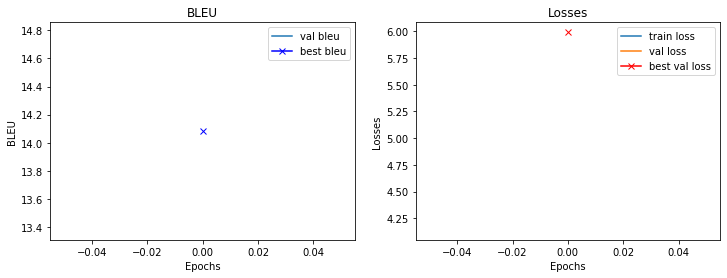

Epoch : 2000
Train example :
	Target: a lady in action with a video game remote control .
	Output: a man in a of a wii game . .
Random example:
	Target: a small red boat floating on a body of water .
	Output: a man is riding a bike down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding a umbrella on a bench .
Train loss    : 3.367235407114029
Val loss      : 6.494709637753039
Val bleu      : 18.60515939044842



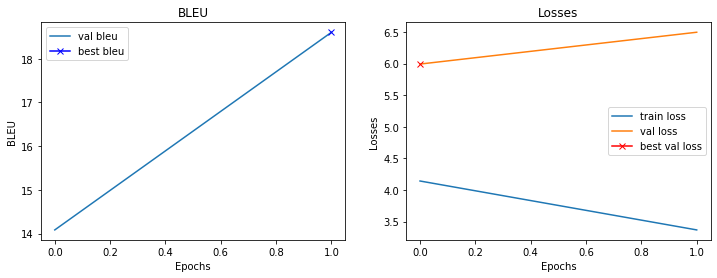

Epoch : 3000
Train example :
	Target: someone laying in the grass beside a frisbee
	Output: a is on a grass with a frisbee . .
Random example:
	Target: an eight book boxed set collection of a story .
	Output: a man is riding a skateboard down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding a umbrella umbrella on a beach .
Train loss    : 3.1421472425460815
Val loss      : 6.712716969694226
Val bleu      : 19.751995349790572



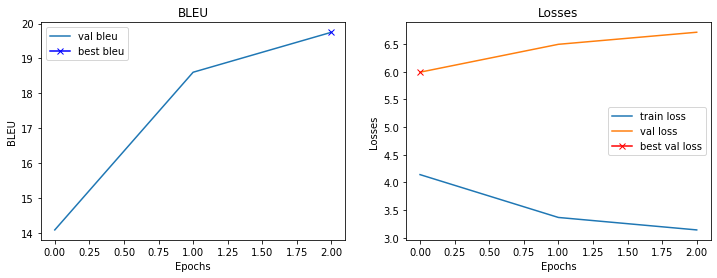

Epoch : 4000
Train example :
	Target: a very large city sitting along side of a large body of water .
	Output: a bench large bench bench on a of a bench bench of water .
Random example:
	Target: this is a stuffed animal on the concrete
	Output: a close up of a person holding a hot dog .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding a umbrella in her hand .
Train loss    : 3.0324228534698485
Val loss      : 6.884903344358532
Val bleu      : 21.02729620525706



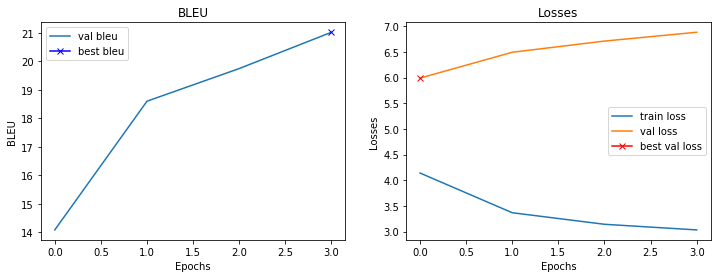

Epoch : 5000
Train example :
	Target: a funny UNK street sign in germany
	Output: a street street sign sign with front a . . . . . . . . . . . .
Random example:
	Target: several trunks in a wood cart with wheels near water .
	Output: a cat sitting on a chair next to a window .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding a umbrella in a park .
Train loss    : 2.9463262155056
Val loss      : 6.9258176782913
Val bleu      : 21.297312130090912



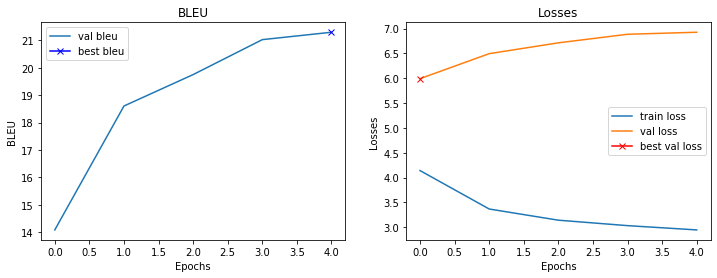

Epoch : 6000
Train example :
	Target: a person riding a snow board on a snowy slope
	Output: a man on skis snowboard board on a snowy day .
Random example:
	Target: men in uniforms playing baseball in the field
	Output: a bus driving down a street next to a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella umbrella in the rain .
Train loss    : 2.899184498548508
Val loss      : 7.0340374207432035
Val bleu      : 20.730735143090865



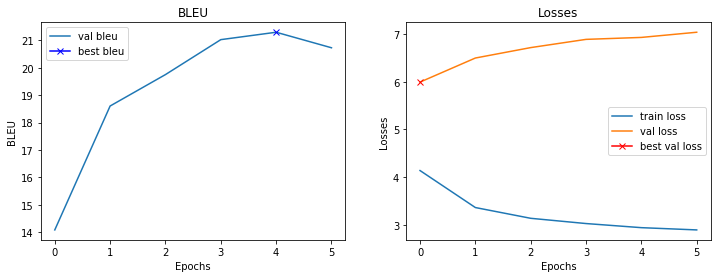

Epoch : 7000
Train example :
	Target: electronic devices are underneath a flat screen television .
	Output: a devices sitting sitting on UNK screen tv .
Random example:
	Target: a kitchen is shown with a table and a oven .
	Output: a man standing in a living room playing wii .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding an umbrella in a park .
Train loss    : 2.8472571392059325
Val loss      : 7.029622641359241
Val bleu      : 21.48976604069448



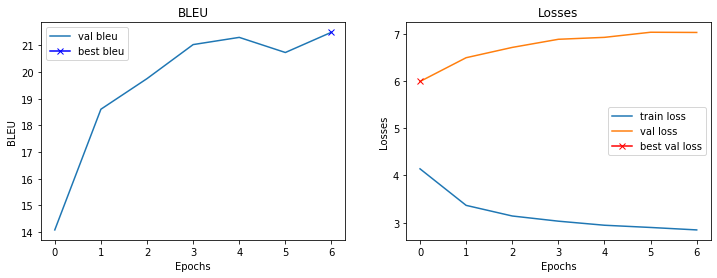

Epoch : 8000
Train example :
	Target: a man laying down on what appears to be bunk beds in a small room .
	Output: a woman is on on a is to a a . . a kitchen room .
Random example:
	Target: two young children are playing together on a wii .
	Output: a train is traveling down the tracks near a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman with a umbrella and a blue umbrella .
Train loss    : 2.8117894167900084
Val loss      : 7.114389884762648
Val bleu      : 21.850337072955227



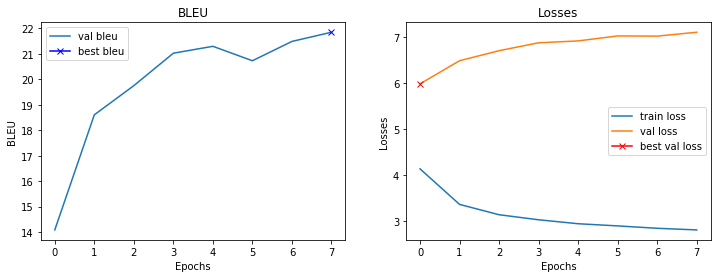

Epoch : 9000
Train example :
	Target: people riding scooters down a busy street in asia .
	Output: a are motorcycles on a street street . the .
Random example:
	Target: three men are posing for a picture on a ski slope .
	Output: a bathroom with a toilet and a toilet
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman is holding an umbrella and a woman .
Train loss    : 2.769392823934555
Val loss      : 7.179429158931825
Val bleu      : 21.737060877247842



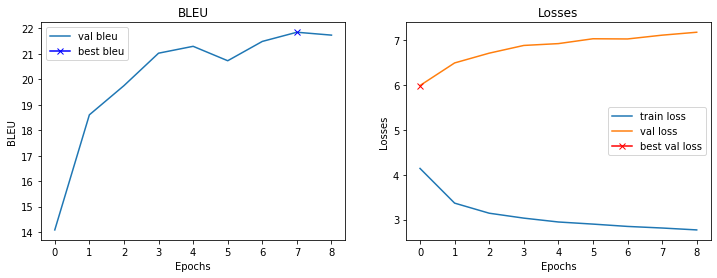

Epoch : 10000
Train example :
	Target: a UNK jet creating condensation flying through the blue sky .
	Output: a plane plane flying on in in a sky sky .
Random example:
	Target: a man is surfing on a red surf board .
	Output: a giraffe standing in the grass next to a tree .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a umbrella is sitting on a beach .
Train loss    : 2.742402628660202
Val loss      : 7.32108618056548
Val bleu      : 21.622530266527708



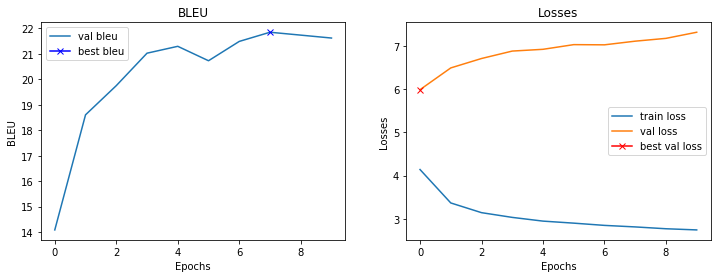

Epoch : 11000
Train example :
	Target: there are many cooks in this kitchen together
	Output: a is many people in the kitchen with .
Random example:
	Target: a young girl is watching a movie of some sorts on a flat screen .
	Output: a teddy bear sitting on a chair in a room .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella and a woman holding a umbrella .
Train loss    : 2.7372727329730986
Val loss      : 7.289271092350244
Val bleu      : 21.88947321578716



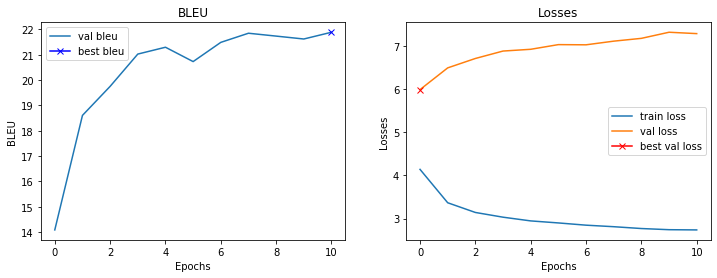

Epoch : 12000
Train example :
	Target: some UNK standing by a trolley car and regular car
	Output: a people buses in a bus on and a
Random example:
	Target: two cars sitting next to each other next to a hill
	Output: a man is skateboarding on a skateboard in the street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella in a field .
Train loss    : 2.7005479984283447
Val loss      : 7.288149731592111
Val bleu      : 22.518251205350175



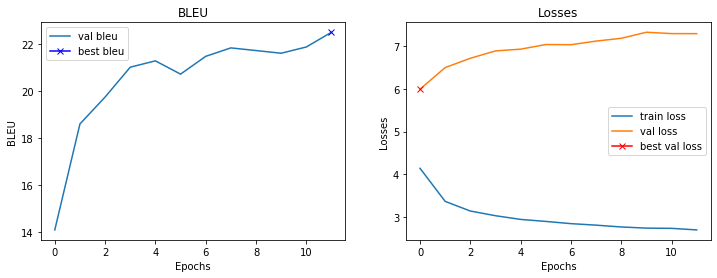

Epoch : 13000
Train example :
	Target: a pair of scissors is being used for a drawer handle .
	Output: a wooden of scissors sitting sitting held on a . . .
Random example:
	Target: an aged picture of a man throwing a baseball , wearing a baseball glove .
	Output: a large clock tower with a clock on it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella umbrella in the rain .
Train loss    : 2.7020451881885528
Val loss      : 7.304206717628127
Val bleu      : 22.036165515186077



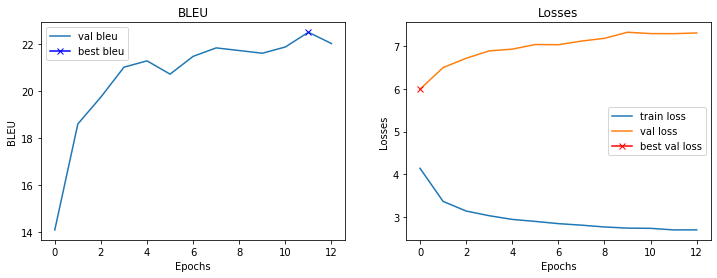

Epoch : 14000
Train example :
	Target: a small pizza with meat and pepper toppings .
	Output: a pizza pizza with a and cheese peppers .
Random example:
	Target: snow covered hills are in the distance of a freeway road with trucks on it .
	Output: a stop sign is shown on a pole .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a woman holding a umbrella umbrella in a park .
Train loss    : 2.6644745962619782
Val loss      : 7.334818537642316
Val bleu      : 22.46062491439661



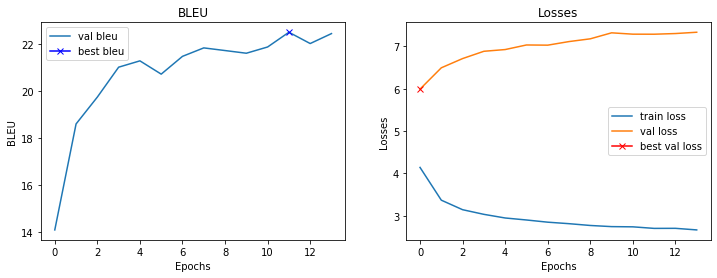

Epoch : 15000
Train example :
	Target: two black bears being kept in an enclosure
	Output: a black and in a a a enclosure . . . . . .
Random example:
	Target: a train station that over looks a mountain range .
	Output: a plate of food with a sandwich and a bowl of soup .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a colorful umbrella while holding a umbrella .
Train loss    : 2.6475679326057433
Val loss      : 7.374083250195676
Val bleu      : 23.145542950905924



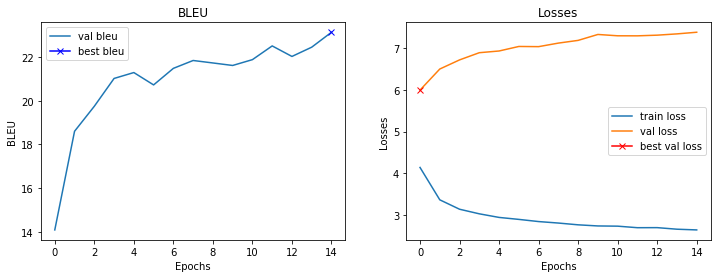

Epoch : 16000
Train example :
	Target: a tennis player concentrates as she strikes the ball .
	Output: a man player is a tennis with the ball .
Random example:
	Target: a reflection of a dog sticking its head out a car window
	Output: a kitchen with a stove , sink , and a refrigerator .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a colorful umbrella while holding a kite .
Train loss    : 2.62672581076622
Val loss      : 7.463608625458508
Val bleu      : 22.527866911179785



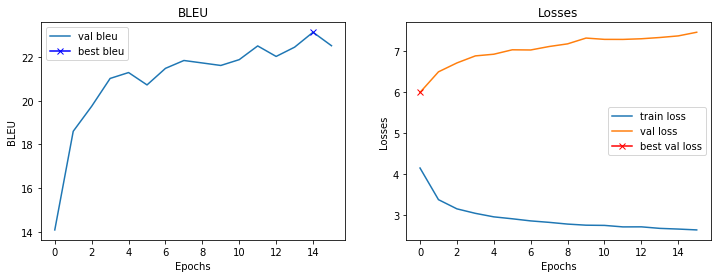

Epoch : 17000
Train example :
	Target: a group of animals standing on top of a dry grass field .
	Output: a herd of cows standing in top of a grass grass field .
Random example:
	Target: a man standing in the middle of a snow covered field .
	Output: a man riding a skateboard up a ramp .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a kite in the air .
Train loss    : 2.634977829217911
Val loss      : 7.463686733711056
Val bleu      : 23.09475206560783



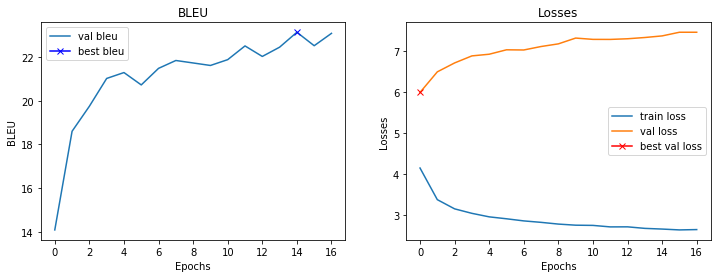

Epoch : 18000
Train example :
	Target: there are three woman riding horses down a beach
	Output: two is two people riding on on the beach .
Random example:
	Target: a moped head light and mirror close up .
	Output: a woman is standing on a street with a stop sign .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.610745795249939
Val loss      : 7.470646227601421
Val bleu      : 22.900600818574706



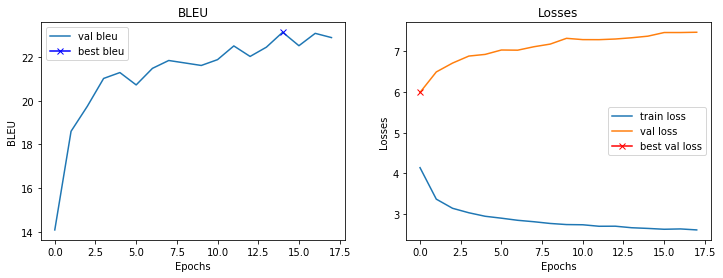

Epoch : 19000
Train example :
	Target: a couple of people walking from an alley way between some buildings .
	Output: a large of people are across a airport in . a buildings .
Random example:
	Target: inside the archway is a glimpse into the other rooms of the house .
	Output: a man with a backpack and a backpack .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a kite in his hand .
Train loss    : 2.597240862488747
Val loss      : 7.4799413021987045
Val bleu      : 22.44092563274945



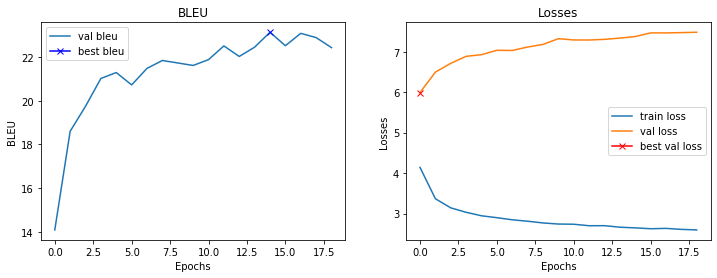

Epoch : 20000
Train example :
	Target: a man is catching air while surfing on a wave
	Output: a man on riding a on riding on a surfboard .
Random example:
	Target: the carrot cake is on a plate on the table
	Output: a parking meter sitting on the side of a road .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a colorful umbrella while standing in the rain .
Train loss    : 2.58177667593956
Val loss      : 7.50783250777702
Val bleu      : 23.10613405553617



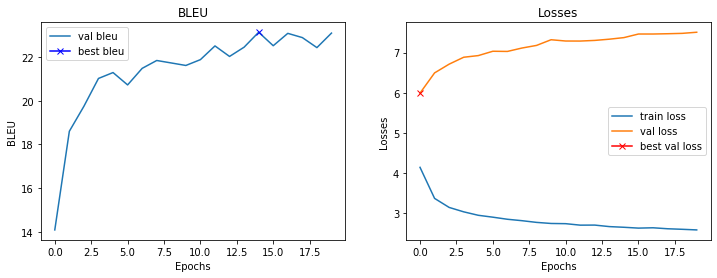

Epoch : 21000
Train example :
	Target: a bath room with a window a sink and a mirror
	Output: a bathroom room with a sink and mirror and a mirror
Random example:
	Target: a plastic container filled with different types of vegetables .
	Output: a man in a wheelchair is riding a motorcycle .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while holding an umbrella .
Train loss    : 2.5705198299884797
Val loss      : 7.496034871595016
Val bleu      : 22.94411680678256



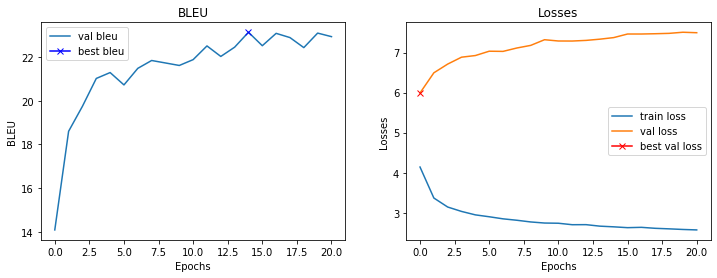

Epoch : 22000
Train example :
	Target: a train pulling away from a train stop .
	Output: a train is into from a station station .
Random example:
	Target: a group of skiers in action on a snowy hill .
	Output: a teddy bear is sitting on a chair .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella while standing in a field .
Train loss    : 2.5889747042655946
Val loss      : 7.511870668509466
Val bleu      : 22.811063559791826



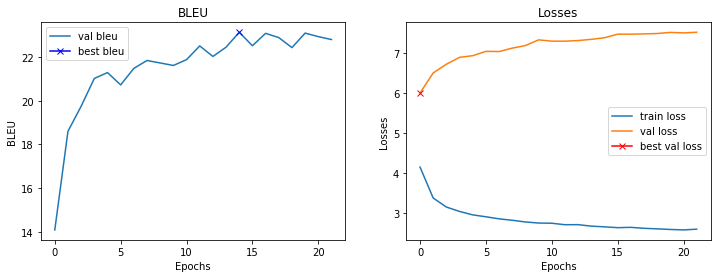

Epoch : 23000
Train example :
	Target: an elephant in a water hole under a waterfall .
	Output: a elephant walking a zoo near of a tree .
Random example:
	Target: the showroom contains several makes and models of trucks .
	Output: a clock on the side of a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a kite under an umbrella .
Train loss    : 2.5549180912971496
Val loss      : 7.567823017192727
Val bleu      : 22.94475969893581



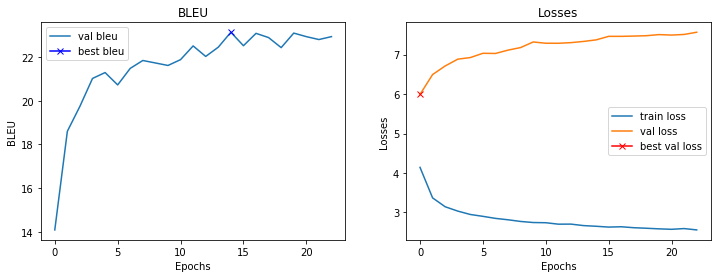

Epoch : 24000
Train example :
	Target: a bird perches itself on a UNK hand while eating .
	Output: a bird perched on on a branch branch .
Random example:
	Target: a room that has a desk with two computer monitors on it .
	Output: a man in a white shirt and a frisbee in a park .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a hat and a hat and a hat .
Train loss    : 2.5594617438316347
Val loss      : 7.5297069833853705
Val bleu      : 22.63369429187127



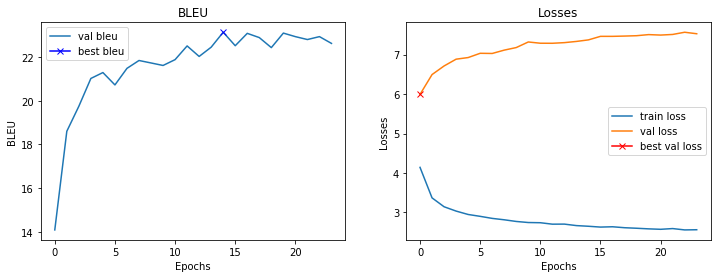

Epoch : 25000
Train example :
	Target: a kitchen with a metal stove top oven .
	Output: a kitchen with a stove stove and oven and
Random example:
	Target: a male and a female the male has a cellphone the female a bottle of water
	Output: a city street with a city street with cars and buildings .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella while standing in the rain .
Train loss    : 2.5451561650037764
Val loss      : 7.586293058989817
Val bleu      : 22.930686308259705



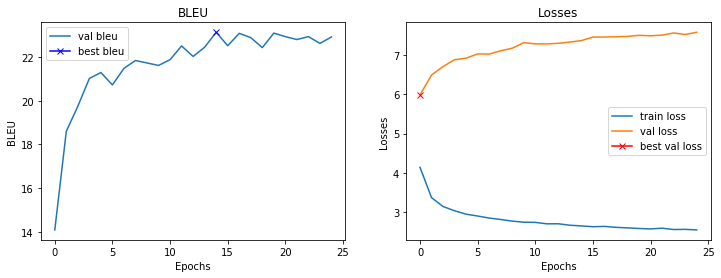

Epoch : 26000
Train example :
	Target: a motorcycle sitting on the side of the road .
	Output: a motorcycle parked on a side of a road .
Random example:
	Target: a person balancing on a skateboard on the curb of a sidewalk .
	Output: a pizza with a lot of toppings on it
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella while standing in the grass .
Train loss    : 2.523491920232773
Val loss      : 7.5791078789770445
Val bleu      : 23.784229295750148



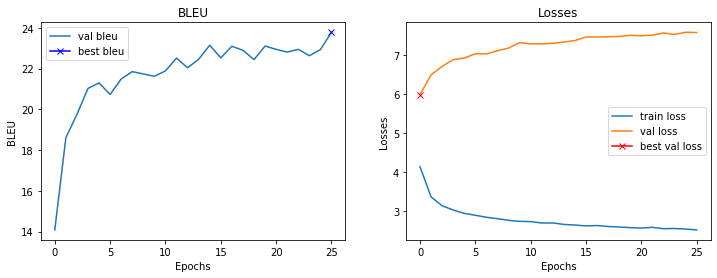

Epoch : 27000
Train example :
	Target: a UNK of a man and his friends going in to an event
	Output: a group of people man and woman friend together together a their event . . . . . . .
Random example:
	Target: a person in a wheelchair plays music on a cd player while talking on a wireless telephone .
	Output: a large building with a clock on the top of it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.5209429593086243
Val loss      : 7.547374486277097
Val bleu      : 24.38122577782533



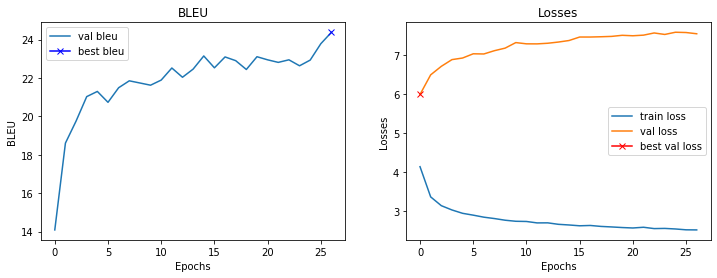

Epoch : 28000
Train example :
	Target: a bathroom decorated in grey and pink .
	Output: a bathroom with with a and white with
Random example:
	Target: a grey and white building with clock tower by palm trees .
	Output: a group of people riding on top of a elephant .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.5025122764110566
Val loss      : 7.6525185579853
Val bleu      : 24.115157585915846



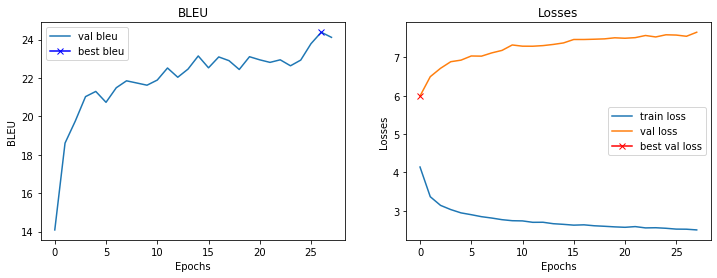

Epoch : 29000
Train example :
	Target: a couple of giraffes are standing in a field
	Output: two giraffe of giraffes standing standing in a zoo .
Random example:
	Target: a large red bus parked in a lot .
	Output: a man sitting on a bed with a laptop computer .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a kite in a field .
Train loss    : 2.5004036779403687
Val loss      : 7.563672094164179
Val bleu      : 23.92460544617624



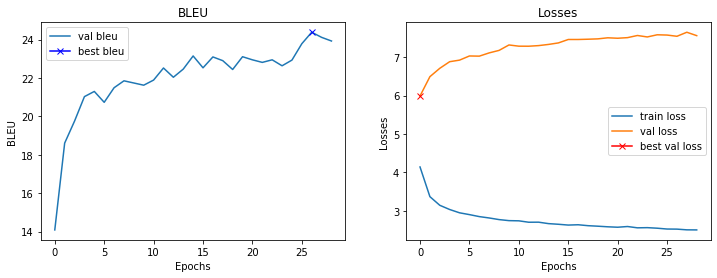

Epoch : 30000
Train example :
	Target: some people standing with a bunch of horses
	Output: a people are around a horse of horses .
Random example:
	Target: a man holding a banana in his hand .
	Output: a bathroom with a shower curtain and a shower curtain .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.487481611609459
Val loss      : 7.613827300911673
Val bleu      : 24.054901182708207



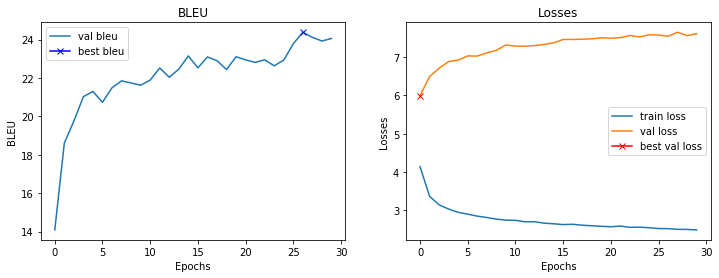

Epoch : 31000
Train example :
	Target: the man is on the tennis court playing a game of tennis .
	Output: a tennis is playing the tennis court with tennis game of tennis .
Random example:
	Target: a river , with several boats , surrounded by trees .
	Output: a pair of scissors sitting on top of a wooden table .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing on a beach .
Train loss    : 2.4693689910173418
Val loss      : 7.625788801084689
Val bleu      : 24.056944908862786



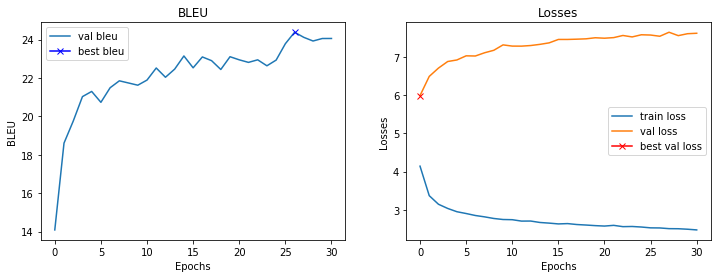

Epoch : 32000
Train example :
	Target: a person is skiing down a snow covered hill .
	Output: a person on skiing down a snowy hill hill .
Random example:
	Target: a man standing in a kitchen looking at a magazine
	Output: a plate of food with a fork and knife .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.475403044700623
Val loss      : 7.609521476879999
Val bleu      : 24.15628193870387



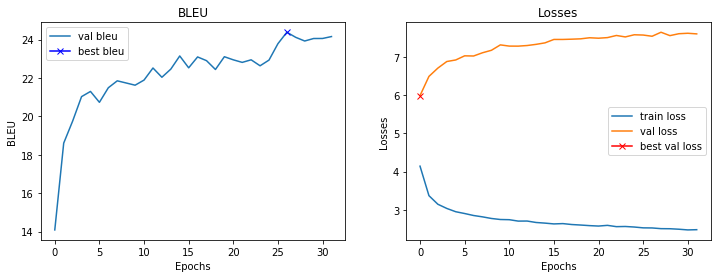

Epoch : 33000
Train example :
	Target: the motorcycle with a side car drives toward a lighthouse .
	Output: a motorcycle is parked man of on down the road .
Random example:
	Target: a pizza with a slice cut out of it
	Output: a woman in a red dress is playing tennis
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4712806277275083
Val loss      : 7.58120484856086
Val bleu      : 23.84490407267905



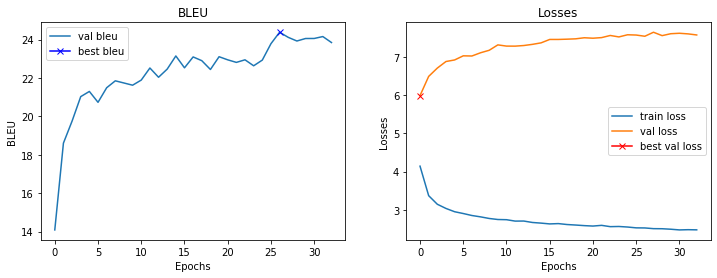

Epoch : 34000
Train example :
	Target: a bathroom toilet that is underneath a window .
	Output: a bathroom with with is in a shower .
Random example:
	Target: a thermometer on a post stuck in the sand of a beach .
	Output: a bear that is standing on a rock
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing on a field .
Train loss    : 2.4710545550584793
Val loss      : 7.633139820925912
Val bleu      : 23.918675600937686



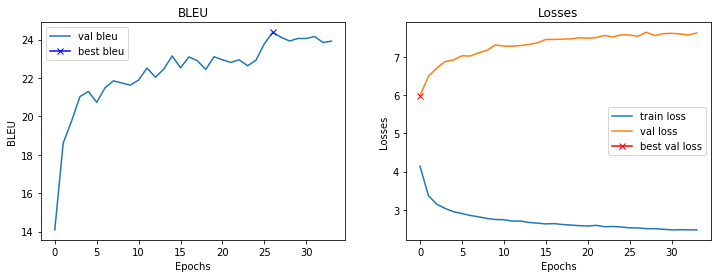

Epoch : 35000
Train example :
	Target: a clock in wooden frame covered by a wreath .
	Output: a clock with a glass with in a window .
Random example:
	Target: a hand holding a remote control next to a bottle of pills .
	Output: a cat is sitting on a couch with a laptop .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a kite in the rain .
Train loss    : 2.469242905139923
Val loss      : 7.664089333397263
Val bleu      : 23.876841512256483



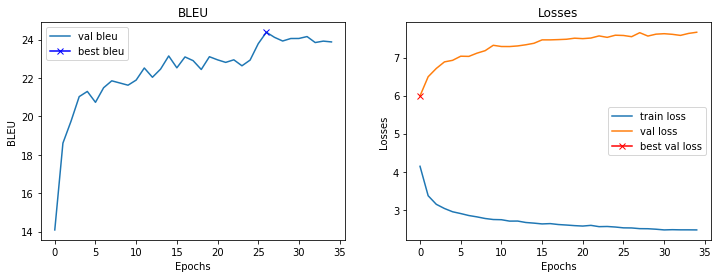

Epoch : 36000
Train example :
	Target: a double decker bus parked under some kind of roof .
	Output: a double decker bus parked in a trees of windows .
Random example:
	Target: a man standing on top of a base wearing a catchers mitt .
	Output: a bus driving down a street next to a bus .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a umbrella while standing in the grass .
Train loss    : 2.460434991002083
Val loss      : 7.592357971480868
Val bleu      : 24.181513289613623



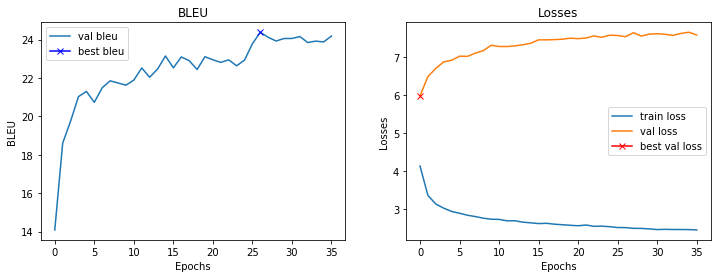

Epoch : 37000
Train example :
	Target: a long passenger train that is going quickly down the track .
	Output: a train train train on is on down . the tracks
Random example:
	Target: an elderly woman wrapped in a shawl walks by , gripping the shoulder strap of her bag .
	Output: a baby elephant standing next to a baby elephant .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man in a black shirt and a red umbrella
Train loss    : 2.4586074287891386
Val loss      : 7.627910975841326
Val bleu      : 24.13319966015799



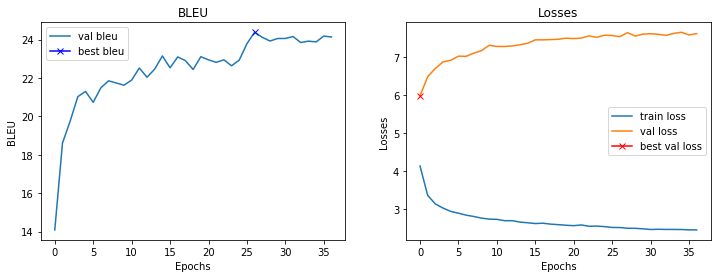

Epoch : 38000
Train example :
	Target: a horse and donkeys standing up in a field of grass , next to a fence and tree .
	Output: a horse standing a horse in in a field . grass . one to a fence . a .
Random example:
	Target: the big grey bear is staring at something
	Output: a large white bird flying through the sky .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a colorful umbrella while standing in the grass .
Train loss    : 2.453673591852188
Val loss      : 7.620823732236537
Val bleu      : 24.238850246205757



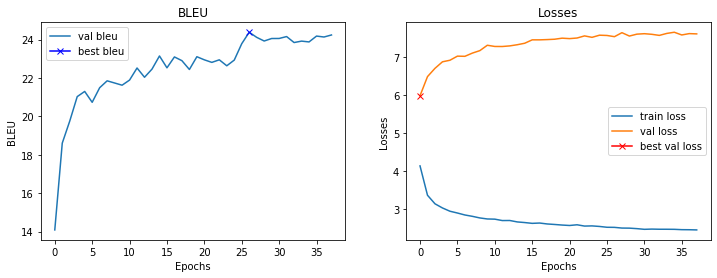

Epoch : 39000
Train example :
	Target: the graveyard in front of the church is very UNK .
	Output: a clock of the of a building has a large .
Random example:
	Target: a woman is on a tennis court holding a ball and racket .
	Output: a boat is in the water with a large body of water .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.460222998023033
Val loss      : 7.723869301762361
Val bleu      : 24.08464572685601



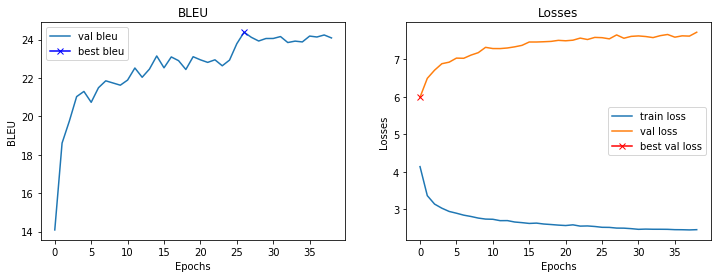

Epoch : 40000
Train example :
	Target: a white plate holding food that includes broccoli .
	Output: a plate plate topped a and a broccoli .
Random example:
	Target: a unfinished bathroom with a toilet and tiled walls
	Output: a group of people walking down a street with a bus .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4423082612752913
Val loss      : 7.645084294523327
Val bleu      : 24.01348739747858



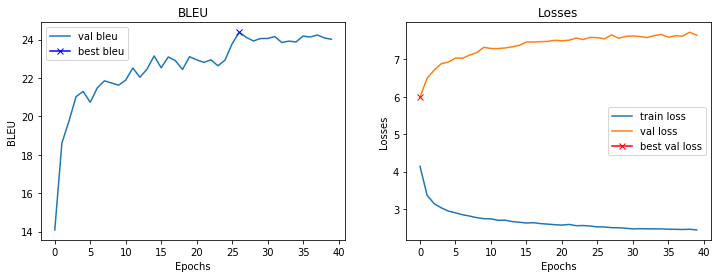

Epoch : 41000
Train example :
	Target: a commuter train sits on tracks bordered by trees .
	Output: a train train traveling on the next by trees .
Random example:
	Target: a cow sitting in the sand at a beach .
	Output: a group of people standing around a boat .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4440557290315628
Val loss      : 7.6868872577905005
Val bleu      : 24.166362302595303



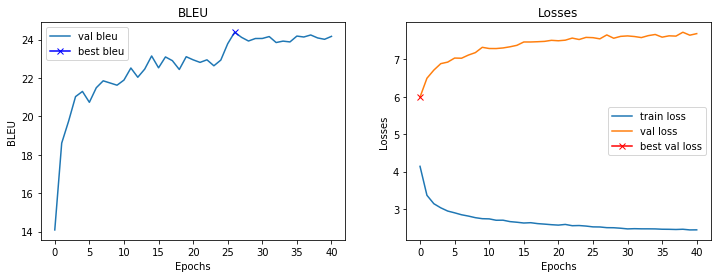

Epoch : 42000
Train example :
	Target: a woman holding up a carrot and a piece of celery for a giraffe .
	Output: a woman feeding a a giraffe to a giraffe . a . a . .
Random example:
	Target: a red fire hydrant between some yellow poles
	Output: a large white truck driving down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a rainbow umbrella over his head .
Train loss    : 2.439768084526062
Val loss      : 7.706510455950812
Val bleu      : 24.530011781661106



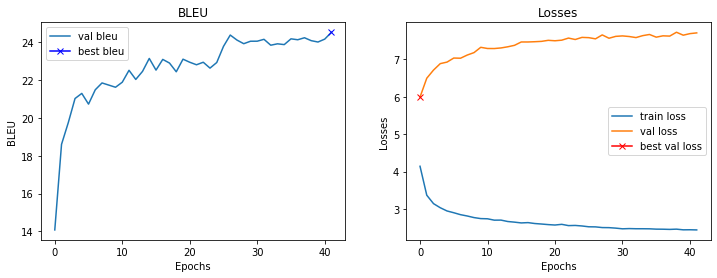

Epoch : 43000
Train example :
	Target: a blender glass with several green vegetables in it .
	Output: a blender filled bowl a liquid liquid in it .
Random example:
	Target: a red headed boy with a baseball bat swinging it at a bag hanging from a tree .
	Output: a table topped with lots of different types of cakes .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man is holding an umbrella while standing in the grass .
Train loss    : 2.4278939747810364
Val loss      : 7.717177778724732
Val bleu      : 24.06938059325765



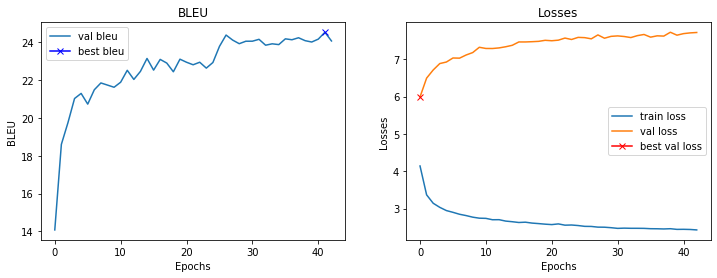

Epoch : 44000
Train example :
	Target: a steam engine is sitting on some train tracks .
	Output: a train is is parked on the tracks tracks .
Random example:
	Target: a stove top sitting under a wooden cabinet .
	Output: a young man is flying a kite on a beach .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4380450482368468
Val loss      : 7.651186442956692
Val bleu      : 24.24047607851376



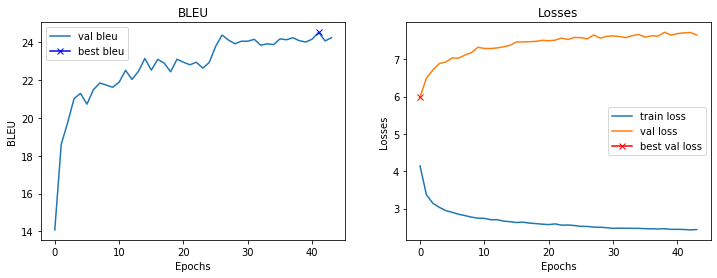

Epoch : 45000
Train example :
	Target: many brown and black sheep bushes grass rocks and trees
	Output: a herd and white sheep are in in and trees
Random example:
	Target: a white plate topped with a cut in half sandwich next to fries and sauce .
	Output: a group of people on skis in the snow .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4221076411008835
Val loss      : 7.694275368842975
Val bleu      : 24.094346033133736



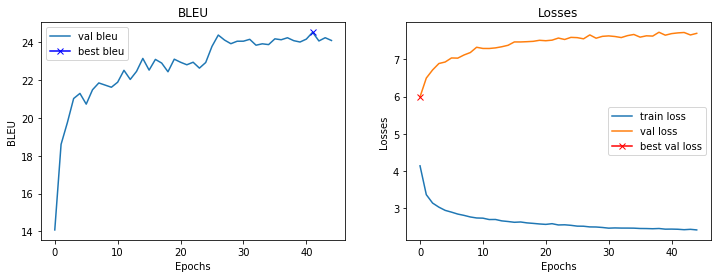

Epoch : 46000
Train example :
	Target: a black cat laying on a pink sheet
	Output: a black cat with on a bed blanket . . . . . . . .
Random example:
	Target: an airplane flying in the air near the airport
	Output: a zebra standing next to a tree in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a rainbow umbrella in a field .
Train loss    : 2.421755523920059
Val loss      : 7.722089552943945
Val bleu      : 24.452027180989873



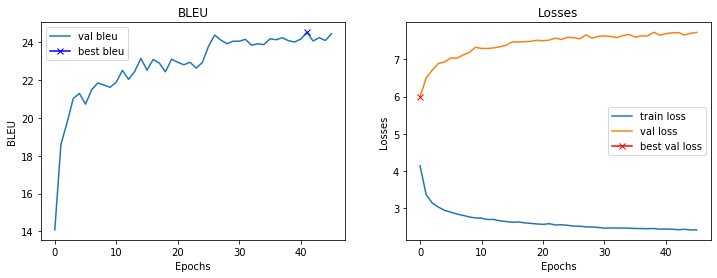

Epoch : 47000
Train example :
	Target: a horse running through a field of grass .
	Output: a horse is through a field with grass .
Random example:
	Target: adult elephant standing near a UNK electric fence .
	Output: a group of people standing around a skateboard .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a rainbow umbrella in a field .
Train loss    : 2.4228404017686844
Val loss      : 7.738018051395572
Val bleu      : 24.278805208316985



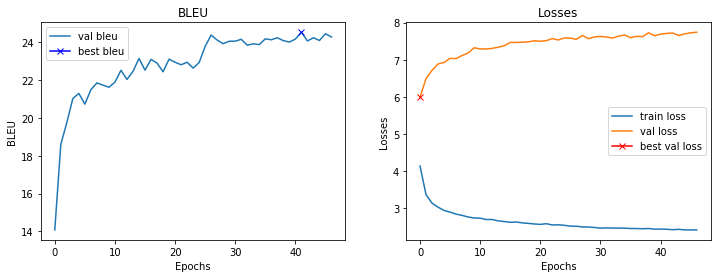

Epoch : 48000
Train example :
	Target: a wooden bench sitting on a lush green park .
	Output: a park bench sitting in top lush green field .
Random example:
	Target: two baseball players that are standing in the dirt .
	Output: two giraffes standing in a field of grass .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.4146429990530014
Val loss      : 7.69809976696645
Val bleu      : 24.822938414847556



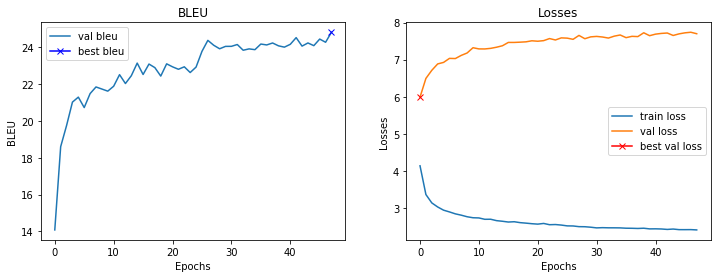

Epoch : 49000
Train example :
	Target: a breakfast tray with fruit , bacon . eggs , and a bagel .
	Output: a plate tray with a and bacon ,
Random example:
	Target: a man laying on top of a bed with his hands under his face .
	Output: a man standing next to a large red and white motorcycle .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding a rainbow colored umbrella in a park .
Train loss    : 2.413181049466133
Val loss      : 7.74297088142333
Val bleu      : 24.196040510857344



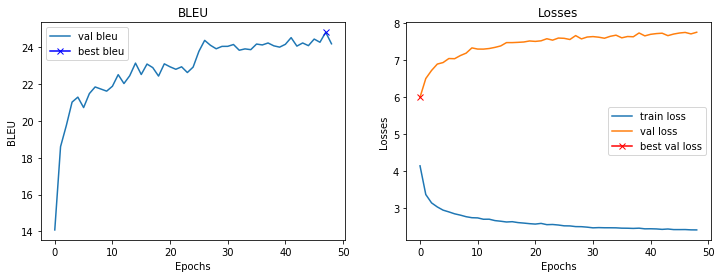

Epoch : 50000
Train example :
	Target: two giraffes are walking in the forest close together .
	Output: a giraffes standing in in a grass .
Random example:
	Target: a public restroom toilet with black rim seat .
	Output: a kitchen with a sink , stove , and a .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man with a umbrella hat is holding an umbrella .
Train loss    : 2.4147805869579315
Val loss      : 7.704084606997689
Val bleu      : 24.003276672365036



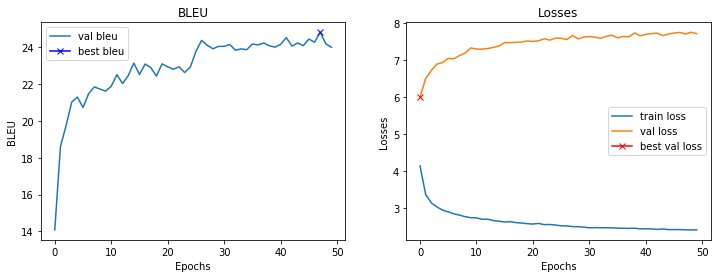

Epoch : 51000
Train example :
	Target: three sheep in a pasture with people standing by the fence .
	Output: a sheep are a field with a looking around them fence .
Random example:
	Target: a woman leaning over a laptop on top of a table .
	Output: a man riding a skateboard down a street .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.401965723514557
Val loss      : 7.757630218981404
Val bleu      : 24.545118075424977



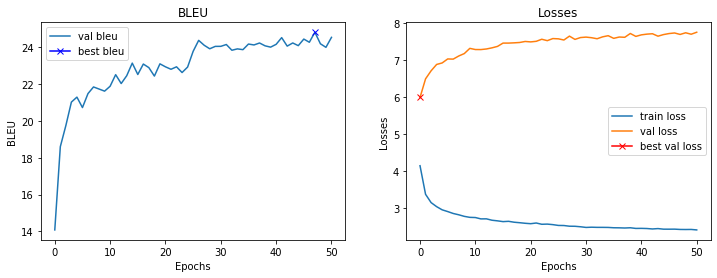

Epoch : 52000
Train example :
	Target: a kitchen counter with spices and mugs on it
	Output: a kitchen with with a and a on the .
Random example:
	Target: a dog sleeping in a dog bed on a floor .
	Output: a man riding a wave on top of a surfboard .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.414385425925255
Val loss      : 7.734150841307188
Val bleu      : 24.518459321869667



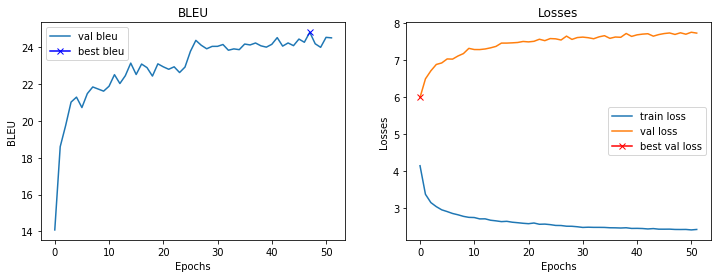

Epoch : 53000
Train example :
	Target: a couple of tall buildings on the water .
	Output: a group of people buildings in a side .
Random example:
	Target: a dog is in a bathroom with chewed toilet paper .
	Output: a woman in a bakery shop with a large amount of doughnuts .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.387010903954506
Val loss      : 7.717738395783959
Val bleu      : 24.26031925303822



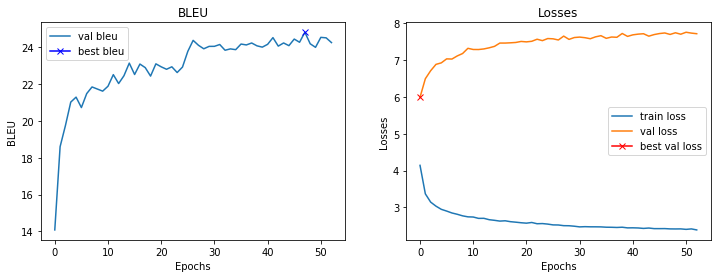

Epoch : 54000
Train example :
	Target: a bathroom with a toilet , sink and printed shower curtain
	Output: a bathroom with a toilet , sink , shower . curtain .
Random example:
	Target: a group of people that are jumping up in the air
	Output: a group of zebras are standing in the grass .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3909202697277068
Val loss      : 7.723745570919378
Val bleu      : 24.477686908223475



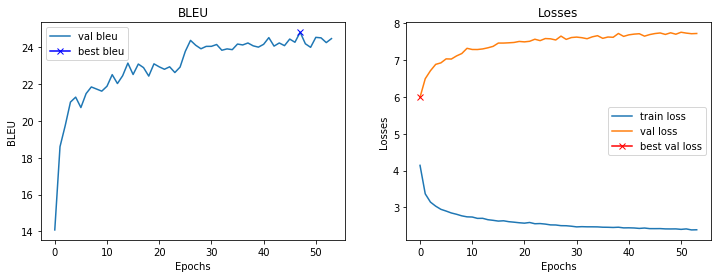

Epoch : 55000
Train example :
	Target: a brown computer desk with a clear glass top with a black keyboard .
	Output: a computer desk desk with a keyboard glass computer . a keyboard keyboard and a .
Random example:
	Target: two parking meters sitting on a sidewalk near a building .
	Output: a red fire hydrant sitting next to a red fire hydrant .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3839611278772352
Val loss      : 7.737601211723597
Val bleu      : 24.62791254861118



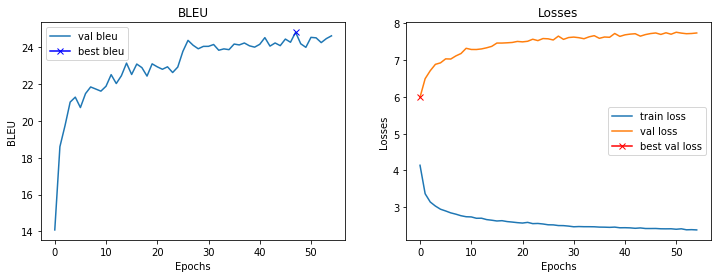

Epoch : 56000
Train example :
	Target: a group of people in a park who are flying their kites .
	Output: a group of people flying a field flying kites flying kites . .
Random example:
	Target: a person next to a small elephant
	Output: a stop sign with a street sign on it .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.373565994024277
Val loss      : 7.778020730832728
Val bleu      : 24.482818539063146



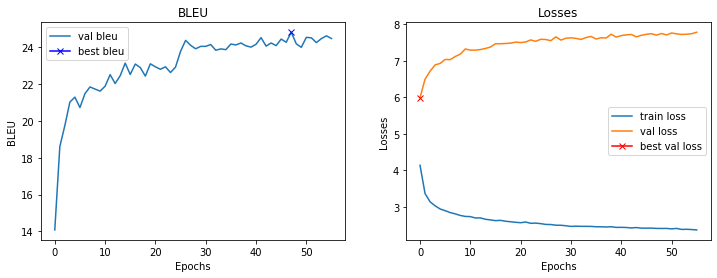

Epoch : 57000
Train example :
	Target: a couple of guys reaching for a UNK be
	Output: a man of people playing for a frisbee
Random example:
	Target: a no parking sign posted to an orange traffic cone in the middle of a sidewalk .
	Output: a group of people playing frisbee in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.383789838075638
Val loss      : 7.738301923281455
Val bleu      : 24.630931715428677



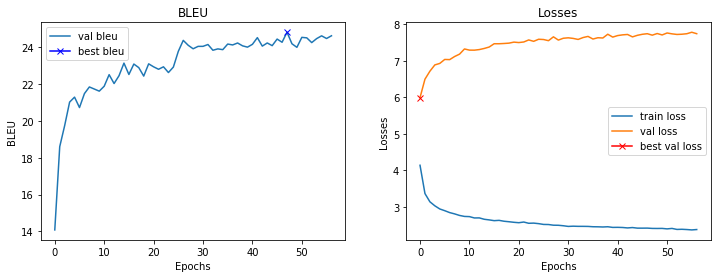

Epoch : 58000
Train example :
	Target: some people chairs and many blue umbrellas and sand
	Output: a people sitting and umbrellas umbrellas umbrellas on a
Random example:
	Target: a man in mid swing of a baseball bat
	Output: a fruit stand with lots of fruit and vegetables .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3684266259670257
Val loss      : 7.787594783596877
Val bleu      : 24.816124692699653



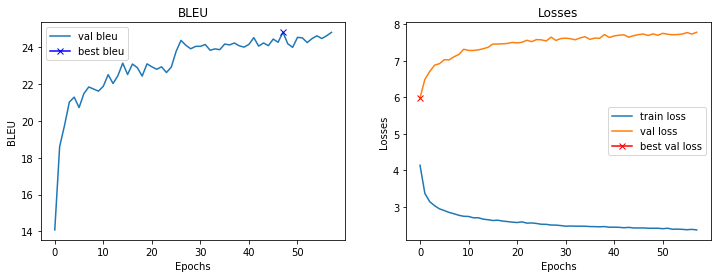

Epoch : 59000
Train example :
	Target: a person flying a kite in the sky
	Output: a man is a kite in the sky .
Random example:
	Target: a large plane flying close to the ground at an airport .
	Output: a baseball player holding a bat on top of a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.387269131422043
Val loss      : 7.719674644108387
Val bleu      : 24.61924161818698



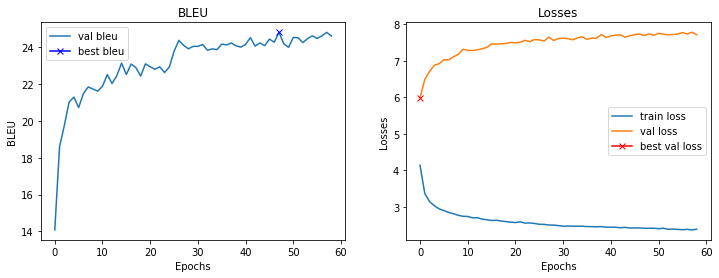

Epoch : 60000
Train example :
	Target: a baseball player holding a bat next to home plate .
	Output: a baseball player swinging a bat on to home plate .
Random example:
	Target: two video game remotes sitting on a table
	Output: a woman standing in a kitchen next to a refrigerator .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3795615820884706
Val loss      : 7.758791008615882
Val bleu      : 24.58773206307687



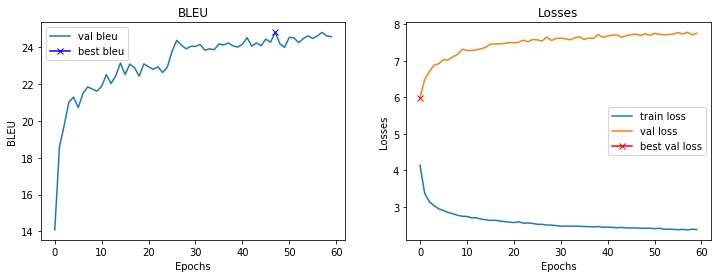

Epoch : 61000
Train example :
	Target: a train traveling through a city next to tall buildings .
	Output: a red on down a city street to a buildings .
Random example:
	Target: th asian tennis player swings for the return volley .
	Output: a white horse standing next to a fence .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.385137611269951
Val loss      : 7.765038730652352
Val bleu      : 24.881491944506212



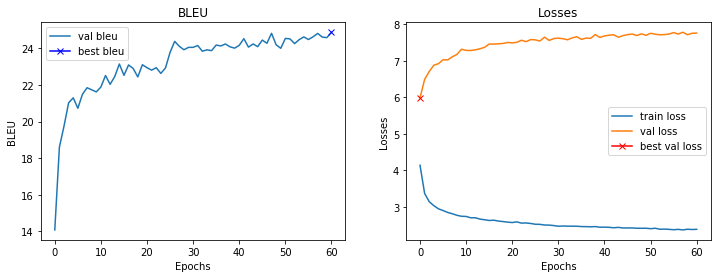

Epoch : 62000
Train example :
	Target: person on a skateboard on a ramp in wooded area .
	Output: a riding a skateboard on a ramp in a area .
Random example:
	Target: a living area with a kitchen and dining room
	Output: a bathroom with a toilet , sink , and shower .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.377205165028572
Val loss      : 7.791567741693843
Val bleu      : 24.85310039126346



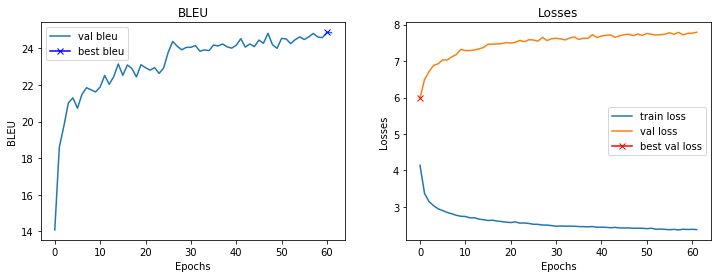

Epoch : 63000
Train example :
	Target: a woman is bending over and reaching into a fridge
	Output: a woman is a over in looking into a microwave . . . . . . . .
Random example:
	Target: a very cute boy smiling and holding luggage .
	Output: a large ornate clock mounted to a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3842864118814466
Val loss      : 7.764472081409237
Val bleu      : 24.54908268332377



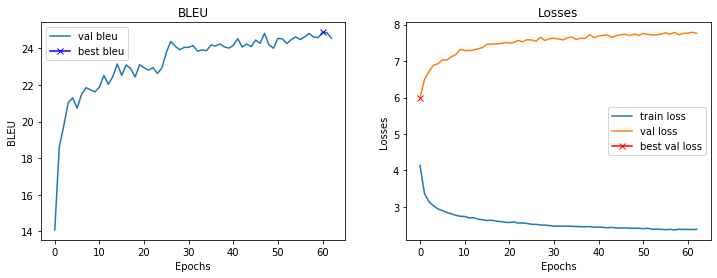

Epoch : 64000
Train example :
	Target: a vintage UNK refrigerator in very poor condition .
	Output: a white refrigerator refrigerator with a dark room .
Random example:
	Target: a close up of a white vase with blue flowers in it .
	Output: a white stove top oven sitting inside of a kitchen .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3845764243602754
Val loss      : 7.737953224802405
Val bleu      : 24.853131994162222



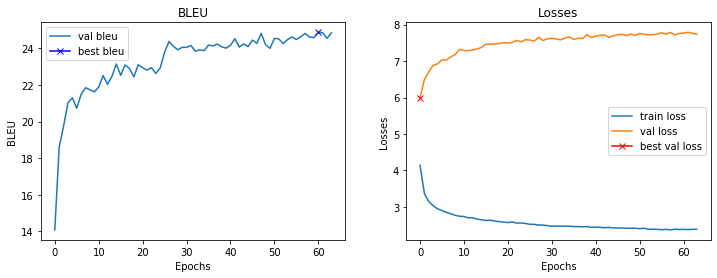

Epoch : 65000
Train example :
	Target: a herd of a cattle grazing in the grass
	Output: a herd of cattle standing in in a grass .
Random example:
	Target: a man standing at a podium while giving a speech .
	Output: a train is traveling down the tracks near a forest .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3780364286899567
Val loss      : 7.745089972891459
Val bleu      : 24.325717988738056



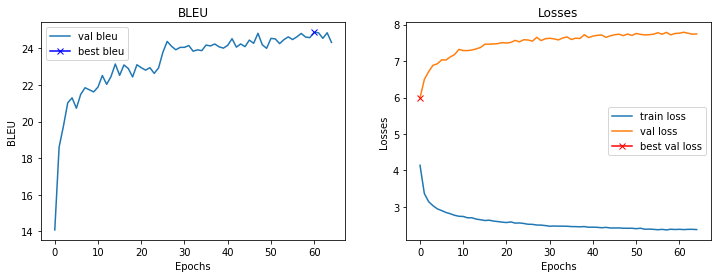

Epoch : 66000
Train example :
	Target: a group of young men play with a frisbee in front of some houses .
	Output: a man of men men playing a a frisbee . a park a grass .
Random example:
	Target: train with oil UNK rides track underneath a blue bridge
	Output: a boat sailing in the water near a large building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3661162532567976
Val loss      : 7.738508035820028
Val bleu      : 24.45557174562515



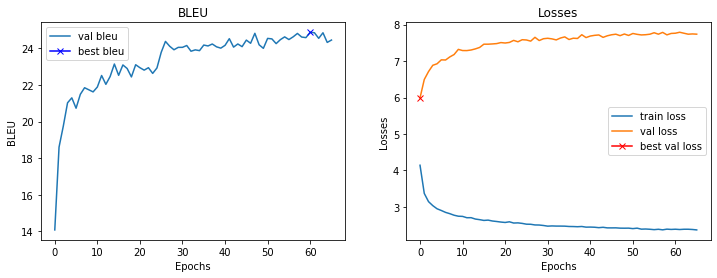

Epoch : 67000
Train example :
	Target: a man riding a wave on top of a surfboard .
	Output: a man riding a wave on top of a surfboard .
Random example:
	Target: a man in a baseball uniform kneeling down while holding a baseball bat .
	Output: a flock of sheep standing in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.376642637372017
Val loss      : 7.780855689268448
Val bleu      : 24.798688219677835



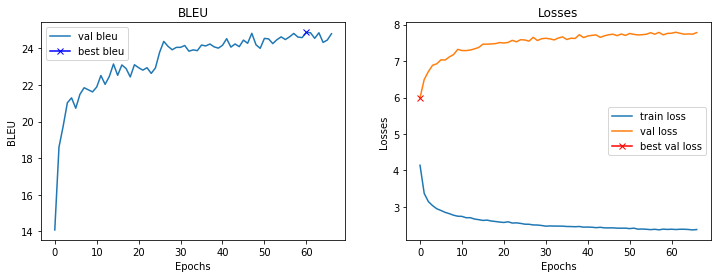

Epoch : 68000
Train example :
	Target: a man swinging a baseball bat on a field .
	Output: a baseball swinging a bat bat at a baseball .
Random example:
	Target: a group of three men standing on a baseball field .
	Output: a woman sitting on a bench in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3658273322582244
Val loss      : 7.774931910238291
Val bleu      : 24.552906790496873



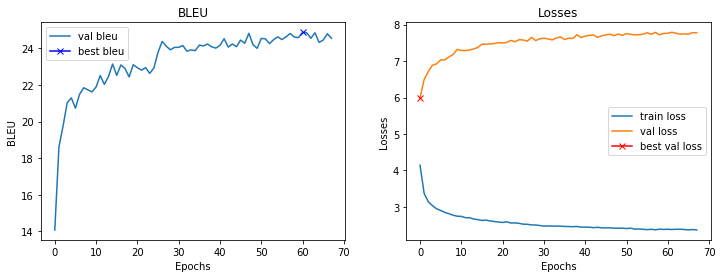

Epoch : 69000
Train example :
	Target: a cat sits in front of an opened window facing a tulip field and windmill .
	Output: a cat is on a of a window window . a house . . a .
Random example:
	Target: a deep dish pizza sitting on top of a white plate .
	Output: a man in a soccer uniform kicking a soccer ball .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in a field .
Train loss    : 2.3794013402462006
Val loss      : 7.758771958389903
Val bleu      : 25.000890948342207



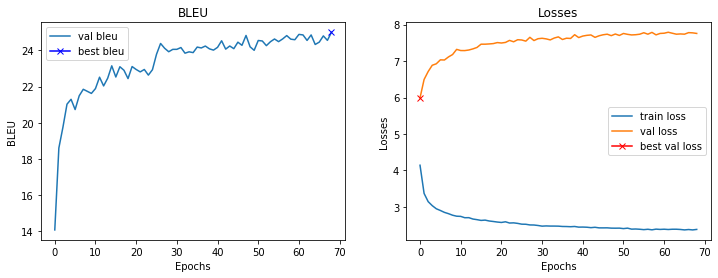

Epoch : 70000
Train example :
	Target: a curved wall with vases setting on small shelves .
	Output: a bunch table with many and a top shelves .
Random example:
	Target: a pile of white stuffed bears laying together .
	Output: a living room with a couch , coffee table and a television .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing next to a woman .
Train loss    : 2.3683602858781816
Val loss      : 7.771088091015493
Val bleu      : 24.858533472657417



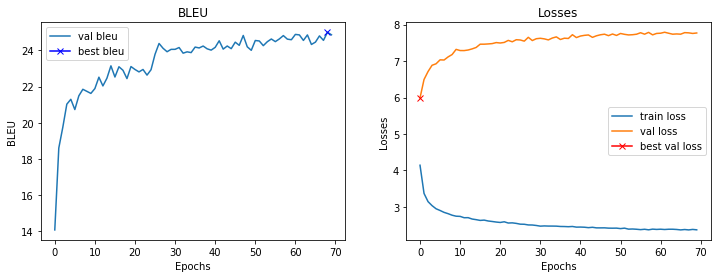

Epoch : 71000
Train example :
	Target: several people on large motorcycles are riding down the street .
	Output: a group are motorcycles are on parked down the street .
Random example:
	Target: two smiling men are playing a wii video game .
	Output: a group of elephants standing next to each other .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.353469508767128
Val loss      : 7.75740354817088
Val bleu      : 24.7342537905131



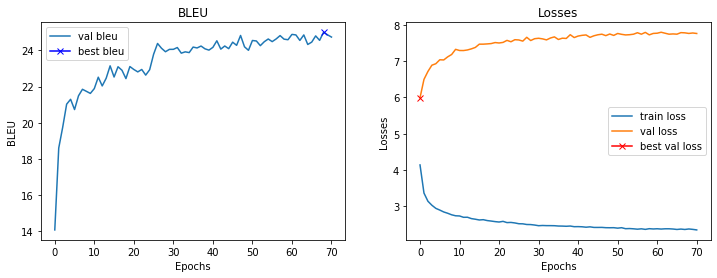

Epoch : 72000
Train example :
	Target: couple sailing a large sailboat on calm water .
	Output: a of sail sail sail sailing a water .
Random example:
	Target: a man riding a surfboard in a body of water .
	Output: a man in a suit and tie standing next to a woman .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in a field .
Train loss    : 2.3521936007738113
Val loss      : 7.7526266400407
Val bleu      : 24.50458661366815



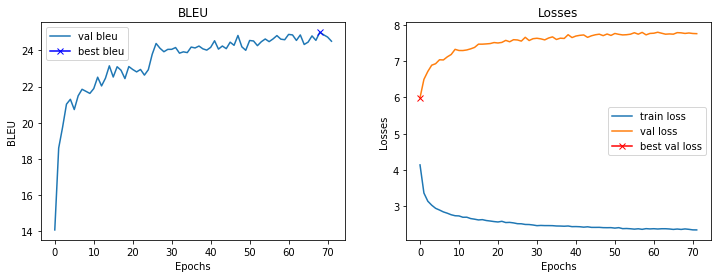

Epoch : 73000
Train example :
	Target: there is a small glass vase with white flowers in it
	Output: a are a vase vase vase with flowers flowers in it
Random example:
	Target: a herd of animals grazing on a pile of hay .
	Output: a zebra standing next to a zebra in a field .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.349428531765938
Val loss      : 7.783831322419288
Val bleu      : 24.451558782744645



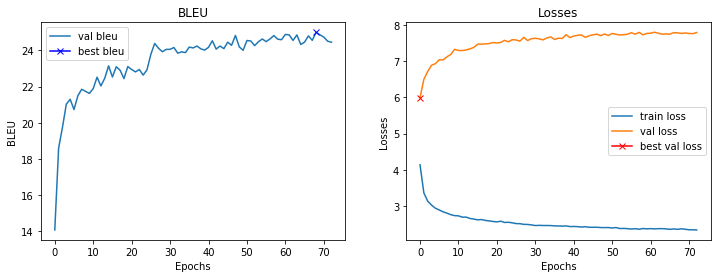

Epoch : 74000
Train example :
	Target: a plate that has a sandwich , chips , and salad on it .
	Output: a plate with has some sandwich and potatoes and a a . it .
Random example:
	Target: a beach filled with people and kites being flown
	Output: a bus is parked in front of a building .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.3547582070827486
Val loss      : 7.772880481833688
Val bleu      : 24.778456766881696



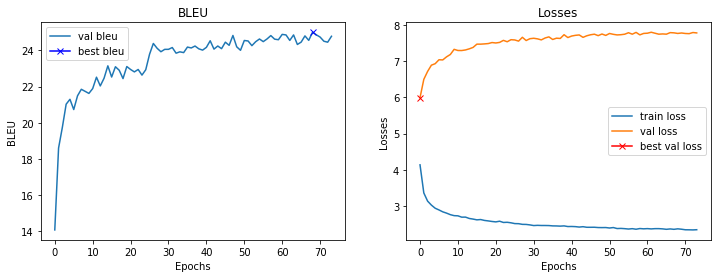

Epoch : 75000
Train example :
	Target: a brown and black cat resting beside the wheel of a bicycle .
	Output: a cat and black cat sitting on a bike of a bicycle .
Random example:
	Target: a man playing a baseball game on the field playing a game
	Output: a group of people on a boat in the water .
Fixed example :
	Target: grits in a bowl with a spoon with two lemons sitting beside the bowl .
	Output: a man holding an umbrella while standing in the grass .
Train loss    : 2.348182389974594
Val loss      : 7.830009260151767
Val bleu      : 25.016850634516597



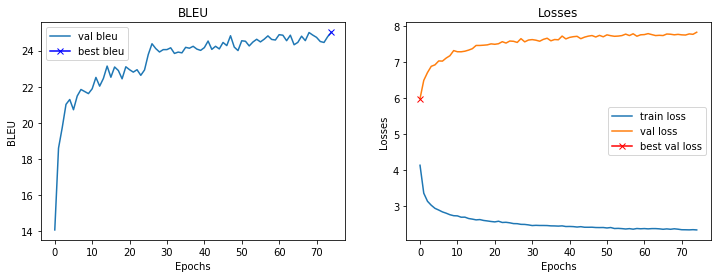

CPU times: user 53min 7s, sys: 30min 55s, total: 1h 24min 3s
Wall time: 1h 24min 45s


In [66]:
%%time
best_bleu = 0
epoch_loss = 0
train_losses = []
val_losses = []
bleu = []
tf = 0.9

for epoch in range(1, max_epochs+1):

  image_vectors, captions_ix = generate_batch(train_img_codes, train_captions, batch_size)
  image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

  captions_ix_next = captions_ix[:, 1:].contiguous()

  network.train()

  optimizer.zero_grad()
        
  outputs = network(image_vectors, captions_ix, teacher_forcing_ratio=tf)
  
  loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
        
  loss.backward()
        
  torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
        
  optimizer.step()

  scheduler.step()
        
  epoch_loss += loss.item()

  if epoch % every_epochs == 0:
    # Выводим произвольный пример для train dataset
    print('Epoch : {}'.format(epoch))
    print('Train example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))
    # Валидируемся
    val_loss, val_bleu = evaluate(network, criterion)   
    print('Train loss    : {}'.format(epoch_loss / every_epochs))
    print('Val loss      : {}'.format(val_loss))
    print('Val bleu      : {}'.format(val_bleu))
    print()
    # Запоминаем новые значения для графиков
    train_losses.append(epoch_loss / every_epochs)
    val_losses.append(val_loss)
    bleu.append(val_bleu)
    # Сохраняем модель с лучшим BLEU
    if val_bleu > best_bleu:
      best_bleu = val_bleu
      torch.save(network.state_dict(), '/content/gdrive/My Drive/Image Captioning/1/v1_model_best_bleu.pt')
    epoch_loss = 0
    # Рисуем графики
    plot_loss()

In [67]:
best_bleu

25.016850634516597

Последняя модель и есть модель с лучшим BLEU.

In [0]:
# Сохраняем веса с последней эпохи
# torch.save(network.state_dict(), '/content/gdrive/My Drive/Image Captioning/1/v1_model_75_epoch.pt')

# Inseption и получение результатов


Перед подачей в нашу модель произвольных картинок, их необходимо предварительно прогнать через Inception v3.

In [0]:
from torchvision.models.inception import Inception3

In [0]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048

        return x_for_attn, x_for_capt 

In [0]:
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.(load_url(inception_url))
    # load_state_dict(torch.load('/content/gdrive/My Drive/Image Captioning/inception_v3_google-1a9a5a14.pth')) #
    return model

In [72]:
%%time
inception = beheaded_inception_v3().train(False)

CPU times: user 3min 48s, sys: 2.51 s, total: 3min 50s
Wall time: 3min 52s


Напишем функции, которые будут помогать строить описания произвольных картинок. Описания будем генерировать разными способами:


1.   **Argmax** (брать на каждом шаге наиболее вероятное слово)
2.   **Sample** (брать на каждом шаге слово в соответствии с полученными вероятностями)
3.   **Beam search** (на каждом шаге рассматривать k наиболее вероятных вариантов)



In [0]:
def generate_captions(image, num_samples=5, max_len=100, top_k=3, t=1.):

    plt.imshow(img)
    plt.show()

    print('argmax:')
    print()
    generate_caption(img, max_len=max_len)
    print()

    print('samples:')
    print()
    for i in range(num_samples):
        generate_caption(img, mode='sample', max_len=max_len, t=t)
    print()

    print('beam search:')
    print()
    generate_caption(img, mode='beam search', max_len=max_len, top_k=top_k)

In [0]:
def generate_caption(image, mode='argmax', max_len=100, top_k=3, t=1.):
  
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    network.eval()

    with torch.no_grad():

        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0)

        vectors_8x8, vectors_neck = inception(image)

        if mode == 'sample':
            print(network.sample(vectors_neck.to(device), max_len, st=t))
        elif mode == 'beam search':
            seq, seqs = network.beam_search(vectors_neck.to(device), top_k=top_k, max_len=max_len)
            print(translate(seq))
            print()
            print('top {}'.format(top_k))
            print()
            for s in seqs:
              print(translate(s))
        else:
            outputs = network(vectors_neck.to(device), teacher_forcing_ratio=0.)

            print(translate(outputs.argmax(-1)[0].tolist()))

## Модель с наилучшим BLEU

Скачаем пару картинок, чтобы проверить качество генерации на модели с наилучшим значением BLEU, полученным за время обучения:

In [139]:
# Загружаем сохраненные веса
network.load_state_dict(torch.load('/content/gdrive/My Drive/Image Captioning/1/v1_model_best_bleu.pt'))

<All keys matched successfully>

In [0]:
network.eval()
network = network.to(device)

2020-02-22 05:12:21 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


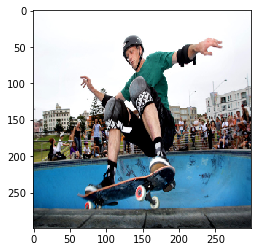

argmax:

a man riding a skateboard down a ramp .

samples:

a skateboarder is doing a trick on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard up a side of a ramp .
a man on a skateboard doing a trick in the air .
a skateboarder is doing a trick on a ramp .

beam search:

a man riding a skateboard down a ramp .

top 3

a man riding a skateboard down a ramp .
a man riding a skateboard down the side of a ramp .
a man riding a skateboard up the side of a ramp .


In [0]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, t=5)

2020-02-22 05:33:42 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


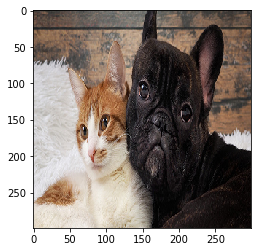

argmax:

a cat is sitting on a chair with a stuffed animal .

samples:

a cat is sitting on a chair with a stuffed animal .
a cat is sitting on a chair with a dog .
a cat is laying down on a blanket .
a small dog is sitting on a chair .
a cat is laying on a blanket with a cat

beam search:

a close up of a dog laying on a bed

top 3

a close up of a cat laying on a bed
a close up of a cat laying on the ground
a close up of a dog laying on a bed


In [0]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

И еще картинки...

2020-02-22 06:03:23 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev [12239/12239] -> "img.jpg" [1]


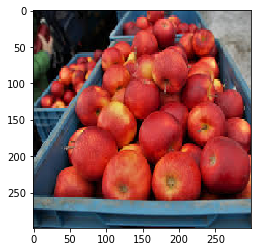

argmax:

a pile of apples sitting on top of a wooden table .

samples:

a box filled with lots of fresh produce .
a pile of apples sitting on a table .
a pile of oranges sitting on a table
a pile of apples and other fruits on display .
a pile of apples sitting on top of a wooden table .

beam search:

a box filled with lots of fresh produce .

top 3

a box filled with lots of fresh produce .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .


In [143]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ7rv-uJi8oL79Hjg9FS5sxkQGrnbC9OaJzLQja5a20rZvpMSev -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

Протестируем различные значения для beam search.

Для 1 получаем уже знакомый argmax:

In [144]:
generate_caption(img, mode='beam search', top_k=1)

a pile of apples sitting on top of a wooden table .

top 1

a pile of apples sitting on top of a wooden table .


In [145]:
generate_caption(img, mode='beam search', top_k=2)

a box filled with lots of fresh produce .

top 2

a box filled with lots of fresh produce .
a box filled with lots of different types of fruit .


In [146]:
generate_caption(img, mode='beam search', top_k=3)

a box filled with lots of fresh produce .

top 3

a box filled with lots of fresh produce .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .


In [147]:
generate_caption(img, mode='beam search', top_k=4)

a box filled with lots of fresh produce .

top 4

a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .


In [148]:
generate_caption(img, mode='beam search', top_k=5)

a box filled with lots of different types of fruits .

top 5

a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .


In [149]:
generate_caption(img, mode='beam search', top_k=6)

a box filled with lots of different types of fruits .

top 6

a box filled with lots of fresh produce
a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .


In [150]:
generate_caption(img, mode='beam search', top_k=7)

a box filled with lots of fresh fruit .

top 7

a box filled with lots of fresh produce
a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of fresh fruit .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .


In [151]:
generate_caption(img, mode='beam search', top_k=8)

a box filled with lots of fresh fruit .

top 8

a box filled with lots of fresh produce
a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of fresh fruit .
a box filled with lots of fruit and vegetables .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .


In [152]:
generate_caption(img, mode='beam search', top_k=9)

a box filled with lots of fresh fruit .

top 9

a box filled with lots of fresh produce
a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of fresh fruit .
a box filled with lots of fruit and vegetables .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .
a pile of oranges sitting on top of a wooden table .


In [153]:
generate_caption(img, mode='beam search', top_k=10)

a box filled with lots of fresh fruit .

top 10

a box filled with lots of fresh produce
a box filled with lots of fresh produce .
a basket filled with lots of fresh produce .
a box filled with lots of fresh fruit .
a box filled with lots of fruit and vegetables .
a box filled with lots of different types of fruit .
a box filled with lots of different types of vegetables .
a box filled with lots of different types of fruits .
a box filled with lots of different types of apples .
a pile of oranges sitting on top of a wooden table .


Увеличение размера луча дает возможность появится более длинным предложениям, но это не всегда приводит к улучшению результата.

2020-02-22 06:04:41 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k [9632/9632] -> "img.jpg" [1]


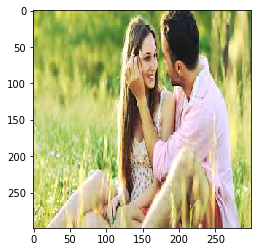

argmax:

a woman sitting on a bench in a field .

samples:

a woman sitting on a bench in the grass .
a woman in a dress sitting on a bench in a field .
a woman sitting on a bench in a field .
a woman and woman sitting on a bench in the woods .
a woman sitting on a bench in the grass .

beam search:

a woman sitting on a bench in the grass .

top 3

a woman sitting on a bench in the grass .
a woman sitting on a bench in a field .
a woman sitting on a bed with a cell phone .


In [154]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTAdN1Fafk0Mk_WhrP3nCcshWW_htjCX8iTigoOIhLjp8bgR50k -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-22 05:42:34 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 [11513/11513] -> "img.jpg" [1]


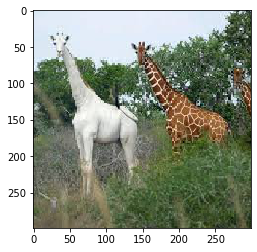

argmax:

a white horse standing next to a white horse .

samples:

a giraffe standing in a grassy field with trees in the background .
a white horse standing next to a white horse .
a white horse is standing in the grass .
a giraffe standing in a field with trees in the background .
a white horse standing next to a white horse .

beam search:

a close up of a giraffe standing in the grass .

top 9

a close up of a giraffe in a field
a close up of a horse in a field
a white horse standing next to a white horse .
a white horse standing next to a brown horse .
a close up of a giraffe standing in the grass
a close up of a horse standing in the grass
a white horse standing next to a lush green field .
a brown and white horse standing next to a tree .
a close up of a giraffe standing in the grass .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQVnxCz-8v2hs8NJg74Q9n8XTbVeDc-MXAn7dBaxbRUaOWeqIz6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=9, t=5)

2020-02-22 06:09:36 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB [14304/14304] -> "img.jpg" [1]


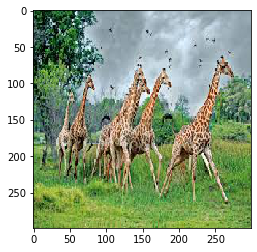

argmax:

a group of giraffes standing in a field .

samples:

a group of giraffes are standing in the grass .
a group of giraffes standing in the grass near a tree .
a group of giraffes in a field with trees in the background .
a group of giraffes standing in a field .
a group of giraffes standing in a field .

beam search:

a group of giraffe standing next to each other .

top 3

a group of giraffe standing next to each other .
a group of giraffe standing next to each other on a field .
a group of giraffe standing next to each other in a field .


In [165]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ54dr99bZ1DJgwVd3mCy8na7cRsLRDENZxuMdDrQRf6Y5p06OB -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-22 05:59:04 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl [12524/12524] -> "img.jpg" [1]


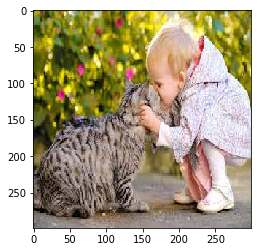

argmax:

a woman is holding a cat and a cat

samples:

a woman is holding a cat in a field .
a woman is laying down with a cat in her lap .
a woman holding a baby sheep in a field .
a woman is laying down with a cat on her lap .
a woman is holding a cat and a cat .

beam search:

a woman is holding a cat in her hand .

top 3

a woman is holding a cat in her hand .
a woman is holding a cat in her hands .
a woman is holding a white frisbee in her hands .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-43Cpwp5gH7q1mfGMAPycqeG4ma1CdZJrAIIP1_HXuILy5ydl -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-22 06:00:35 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


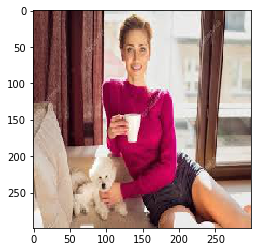

argmax:

a woman sitting on a chair with a dog .

samples:

a woman sitting on a chair with a dog .
a woman sitting on a chair with a dog in her lap .
a woman sitting on a chair with a dog .
a woman sitting on a chair with a teddy bear .
a woman sitting on a chair with a dog .

beam search:

a woman sitting on a couch with a cat .

top 3

a woman sitting on a chair with a dog .
a woman sitting on a couch with a dog .
a woman sitting on a couch with a cat .


In [0]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

2020-02-22 06:05:24 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


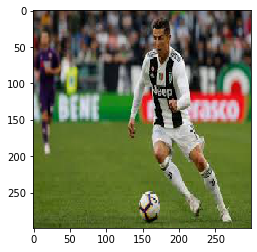

argmax:

a soccer player is kicking a soccer ball .

samples:

a soccer player is kicking a soccer ball .
a soccer player is kicking a soccer ball .
a man is kicking a soccer ball on a field .
a soccer player is kicking a soccer ball .
a soccer player is kicking the ball on the field .

beam search:

a soccer player is kicking a soccer ball .

top 3

a soccer player is kicking a soccer ball .
a soccer player kicking a soccer ball on a field
a soccer player kicking a soccer ball on a field .


In [159]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255. #imresize(img, (299, 299)).astype('float32') / 255.

generate_captions(img, top_k=3, t=5)

Проверим на валидационном датасете при каком размере луча beam search дает наилучший BLEU.

In [0]:
def evaluate_beam_search(model, sample=False, top_k=3, max_len=None, t=1, val_size=len(val_img_codes)):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size
    
    with torch.no_grad():
    
        for i in range(val_size):

            image_vectors, captions_ix_all = val_img_codes[i], train_captions[i]
            
            image_vectors = torch.tensor(image_vectors, dtype=torch.float32).to(device) 
        
            if sample:
                out = network.sample(image_vectors, max_len=max_len, st=t)
                hypotheses.append(out.split())
            else:
                out, outputs = network.beam_search(image_vectors, top_k=top_k, max_len=max_len)
                hypotheses.append(translate(out, to_str=False))

    bleu = corpus_bleu(references, hypotheses)
        
    return bleu*100

In [168]:
best_bleu

25.016850634516597

In [0]:
network.eval()
bleu_k = []
for top_k in range(2, 11):
    bleu = evaluate_beam_search(network, top_k=top_k)
    bleu_k.append(bleu)

In [0]:
bleu_k = [best_bleu] + bleu_k

In [171]:
max(bleu_k)

26.60007954044134

In [172]:
bleu_k

[25.016850634516597,
 26.598885357349623,
 26.60007954044134,
 26.266878715008268,
 25.777817166949063,
 25.48793507086354,
 25.290169182776346,
 25.023568852158228,
 25.001152079423928,
 24.740551619885352]

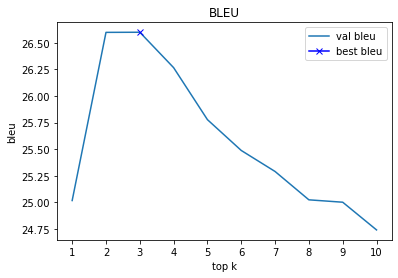

In [173]:
plt.title("BLEU")
plt.plot(bleu_k, label="val bleu")
plt.plot(np.argmax(bleu_k), np.max(bleu_k), marker="x", color="b", label="best bleu")
plt.xticks(np.arange(10), np.arange(1, 11))
plt.xlabel("top k")
plt.ylabel("bleu")
plt.legend()
plt.show()

Наилучший BLEU достигается при k=3. Хотя для k=2 и 3 значения очень близки.